In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam


In [96]:
# This line reads data from an Excel file named 'Centrifugal_pumps_measurements.xlsx' located in the specified directory 
# and loads it into a pandas DataFrame called 'df'. The DataFrame 'df' will contain the data from the Excel sheet
df = pd.read_excel('/kaggle/input/sensor-measurements-of-centrifugal-pumps/Centrifugal_pumps_measurements.xlsx')

In [97]:
df.head()

,Machine_ID,value_ISO,value_DEMO,value_ACC,value_P2P,valueTEMP,minute,second,year,month,day,hour
0,1,0.349609,0.000343,0.012512,0.04248,24.25,33,41,2022,12,7,12
1,1,0.349609,0.000343,0.012512,0.04248,24.25,33,46,2022,12,7,12
2,1,0.349609,0.000343,0.012512,0.04248,24.25,33,51,2022,12,7,12
3,1,0.349609,0.000343,0.012512,0.04248,24.25,33,56,2022,12,7,12
4,1,0.349609,0.000343,0.012512,0.04248,24.25,34,1,2022,12,7,12


# ***Data Cleaning :***

In [98]:
# Shows the count of missing values in each column of the DataFrame.
df.isna().sum()

Machine_ID    0
value_ISO     0
value_DEMO    0
value_ACC     0
value_P2P     0
valueTEMP     0
minute        0
second        0
year          0
month         0
day           0
hour          0
dtype: int64

In [99]:
# Counts the number of null values in each column of the DataFrame.
df.isnull().sum()

Machine_ID    0
value_ISO     0
value_DEMO    0
value_ACC     0
value_P2P     0
valueTEMP     0
minute        0
second        0
year          0
month         0
day           0
hour          0
dtype: int64

**Outlier detection :**

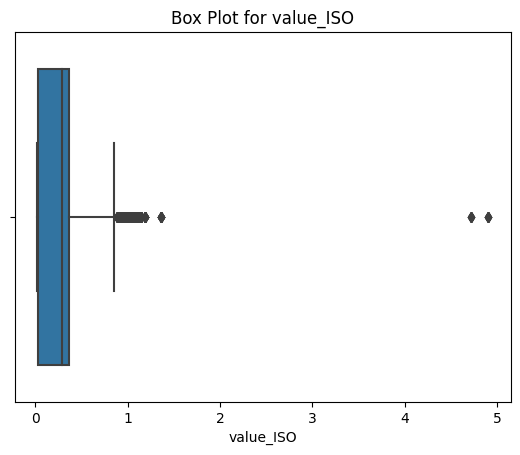

In [100]:
# Generates a box plot for 'value_ISO' to visualize its distribution and identify potential outliers. 
# which can be seen as points outside the whiskers of the box plot.

sns.boxplot(x=df['value_ISO'])
plt.title('Box Plot for value_ISO')
plt.show()

**Handeling outliers**

In [101]:
# Calculate the Interquartile Range (IQR) to identify the spread of the middle 50% of the data in 'value_ISO'.
# Define lower and upper bounds using IQR to detect potential outliers.
# Filter the DataFrame to remove rows where 'value_ISO' falls outside these bounds, effectively handling outliers.

Q1 = df['value_ISO'].quantile(0.25)
Q3 = df['value_ISO'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds using IQR to detect potential outliers.lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove rows where 'value_ISO' falls outside these bounds, effectively handling outliers.
df = df[(df['value_ISO'] >= lower_bound) & (df['value_ISO'] <= upper_bound)]


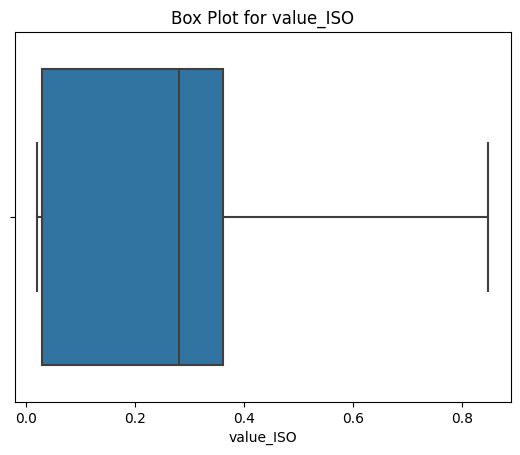

In [102]:
sns.boxplot(x=df['value_ISO'])
plt.title('Box Plot for value_ISO')
plt.show()

In [103]:
# Find and display duplicate rows in the DataFrame

duplicates = df[df.duplicated()]
print("Duplicate rows:")
print(duplicates)


Duplicate rows:
Empty DataFrame
Columns: [Machine_ID, value_ISO, value_DEMO, value_ACC, value_P2P, valueTEMP, minute, second, year, month, day, hour]
Index: []


No duplicates were found

# ***Feature Engineering :***

In [104]:
df.head()

,Machine_ID,value_ISO,value_DEMO,value_ACC,value_P2P,valueTEMP,minute,second,year,month,day,hour
0,1,0.349609,0.000343,0.012512,0.04248,24.25,33,41,2022,12,7,12
1,1,0.349609,0.000343,0.012512,0.04248,24.25,33,46,2022,12,7,12
2,1,0.349609,0.000343,0.012512,0.04248,24.25,33,51,2022,12,7,12
3,1,0.349609,0.000343,0.012512,0.04248,24.25,33,56,2022,12,7,12
4,1,0.349609,0.000343,0.012512,0.04248,24.25,34,1,2022,12,7,12


In [105]:

# Converting minute and second into cyclic features
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
df['second_sin'] = np.sin(2 * np.pi * df['second'] / 60)
df['second_cos'] = np.cos(2 * np.pi * df['second'] / 60)

# Converting hour into cyclic features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Converting day, month, year into categorical features
df['day_of_week'] = pd.to_datetime(df[['year', 'month', 'day']]).dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)


In [106]:
# Computeing rolling mean and standard deviation for value_ISO
df['value_ISO_rolling_mean'] = df['value_ISO'].rolling(window=5).mean()
df['value_ISO_rolling_std'] = df['value_ISO'].rolling(window=5).std()

# Computeing lagged features
df['value_ISO_lag1'] = df['value_ISO'].shift(1)
df['value_ISO_lag2'] = df['value_ISO'].shift(2)

# Interaction features
df['value_ISO_TEMP'] = df['value_ISO'] * df['valueTEMP']


In [107]:
df.drop(columns=['minute', 'second', 'year', 'month'], inplace=True)

In [108]:
# Impute missing values with mean
df['value_ISO_rolling_mean'] = df['value_ISO_rolling_mean'].fillna(df['value_ISO_rolling_mean'].mean())
df['value_ISO_rolling_std'] = df['value_ISO_rolling_std'].fillna(df['value_ISO_rolling_std'].mean())

# Impute missing values using forward fill
df.dropna(subset=['value_ISO_lag1', 'value_ISO_lag2'], inplace=True)

In [109]:
df.columns
df.drop(columns=['value_ISO', 'value_ACC', 'day', 'hour',], inplace=True)

In [110]:
df.columns

Index(['Machine_ID', 'value_DEMO', 'value_P2P', 'valueTEMP', 'minute_sin',
       'minute_cos', 'second_sin', 'second_cos', 'hour_sin', 'hour_cos',
       'day_of_week', 'is_weekend', 'value_ISO_rolling_mean',
       'value_ISO_rolling_std', 'value_ISO_lag1', 'value_ISO_lag2',
       'value_ISO_TEMP'],
      dtype='object')

# ***Test_Train_Split :*** 

In [111]:
# Create a 'health_status' column based on 'Machine_ID': 1 for Machine_ID 2, 0 otherwise
df['health_status'] = df['Machine_ID'].apply(lambda x: 1 if x == 2 else 0)


# Split data
X = df[['value_DEMO', 'value_P2P', 'valueTEMP', 'minute_sin', 'minute_cos', 
        'second_sin', 'second_cos', 'hour_sin', 'hour_cos', 'day_of_week', 
        'is_weekend', 'value_ISO_rolling_mean', 'value_ISO_rolling_std', 
        'value_ISO_lag1', 'value_ISO_lag2', 'value_ISO_TEMP']]

y = df['health_status']  # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**RandomForest Classifier**

In [112]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       526
           1       1.00      1.00      1.00       405

    accuracy                           1.00       931
   macro avg       1.00      1.00      1.00       931
weighted avg       1.00      1.00      1.00       931



**SVM :**

In [113]:
# SVM model with pipeline for scaling and SVM classifier
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling features for SVM
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
])

# Training the model
svm_pipeline.fit(X_train, y_train)

# Predictions
svm_pred_proba = svm_pipeline.predict_proba(X_test)[:, 1]  # Get probability for the positive class
svm_pred = (svm_pred_proba > 0.5).astype(int)  # Convert probabilities to binary class labels

# Evaluating the model
accuracy = accuracy_score(y_test, svm_pred)
print(f'Test Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, svm_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_pred))

Test Accuracy: 0.958109559613319
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       526
           1       0.94      0.97      0.95       405

    accuracy                           0.96       931
   macro avg       0.96      0.96      0.96       931
weighted avg       0.96      0.96      0.96       931

Confusion Matrix:
[[501  25]
 [ 14 391]]


**Neural_Network_Sequential-Model :**

In [114]:
# Defineing the number of input features
input_shape = (X_train.shape[1],)

# Model Building
model = Sequential()

# Add an Input layer
model.add(Input(shape=input_shape))

# Add Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Training the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
dl_pred = model.predict(X_test).flatten()


loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5459 - loss: 0.6787 - val_accuracy: 0.8024 - val_loss: 0.5486
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7431 - loss: 0.5522 - val_accuracy: 0.8056 - val_loss: 0.4197
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7971 - loss: 0.3971 - val_accuracy: 0.8120 - val_loss: 0.3427
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8130 - loss: 0.3538 - val_accuracy: 0.8389 - val_loss: 0.3120
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8167 - loss: 0.3532 - val_accuracy: 0.8808 - val_loss: 0.2922
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8402 - loss: 0.3194 - val_accuracy: 0.9012 - val_loss: 0.2742
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8467 - loss: 0.3012 - val_accuracy: 0.9216 - val_loss: 0.2627
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8526 - loss: 0.2812 - val_accuracy: 0.

# ***Model Ensembling***

In [115]:
# Combining predictions using a weighted average
weights = [0.5, 0.5]
combined_pred_proba = weights[0] * svm_pred + weights[1] * dl_pred

# Converting combined probabilities to binary predictions (threshold = 0.5)
combined_pred = (combined_pred_proba > 0.5).astype(int).flatten()
y_test = y_test  


# Evaluating combined predictions
accuracy = accuracy_score(y_test, combined_pred)
print(f'Combined Model Test Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, combined_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, combined_pred))

Combined Model Test Accuracy: 0.958109559613319
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       526
           1       0.94      0.97      0.95       405

    accuracy                           0.96       931
   macro avg       0.96      0.96      0.96       931
weighted avg       0.96      0.96      0.96       931

Confusion Matrix:
[[501  25]
 [ 14 391]]


# ***Predictions on Test Data :***

In [116]:
# Compairing the predicted health status with the actual health status
comparison = pd.DataFrame({
    'Actual Health Status': y_test,
    'Predicted Health Status': combined_pred.flatten() 
})

print(comparison.head(10))


      Actual Health Status  Predicted Health Status
4412                     1                        1
3067                     0                        0
35                       0                        0
2471                     1                        1
4465                     1                        1
1810                     1                        1
584                      0                        0
1658                     1                        1
1757                     1                        1
1128                     0                        0


In [117]:
# Identify instances predicted to be in a maintenance-prone state (health_status = 1)
maintenance_prone_pumps = comparison[comparison['Predicted Health Status'] == 1]

print(maintenance_prone_pumps)


      Actual Health Status  Predicted Health Status
4412                     1                        1
2471                     1                        1
4465                     1                        1
1810                     1                        1
1658                     1                        1
...                    ...                      ...
4999                     1                        1
4050                     1                        1
4605                     1                        1
2764                     1                        1
4452                     1                        1

[416 rows x 2 columns]


# ***Model Export :***

In [118]:
# Save SVM pipeline and deep learning model to files

import joblib
joblib.dump(svm_pipeline, 'svm_pipeline.pkl')
model.save('dl_model.h5')


In [119]:
import joblib
import numpy as np
from tensorflow.keras.models import load_model
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress specific warning
warnings.simplefilter(action='ignore', category=DataConversionWarning)

# Load the saved models
svm_pipeline = joblib.load('svm_pipeline.pkl')
dl_model = load_model('dl_model.h5')

# Function to perform ensemble prediction
def ensemble_predict(X):
    svm_pred = svm_pipeline.predict_proba(X)[:, 1]  # Get probability for the positive class
    dl_pred = dl_model.predict(X).flatten()   
    # Combine predictions using a weighted average
    combined_pred_proba = 0.5 * svm_pred + 0.5 * dl_pred
    combined_pred = (combined_pred_proba > 0.5).astype(int)
    return combined_pred



# Defining the feature names as used during training
feature_names = ['value_DEMO', 'value_P2P', 'valueTEMP', 'minute_sin', 'minute_cos', 
                  'second_sin', 'second_cos', 'hour_sin', 'hour_cos', 'day_of_week', 
                  'is_weekend', 'value_ISO_rolling_mean', 'value_ISO_rolling_std', 
                  'value_ISO_lag1', 'value_ISO_lag2', 'value_ISO_TEMP']

X_new = np.array([[0.5, 0.8, 75, 0.6, 0.9, 0.2, 0.1, 0.7, 0.5, 0.8, 1, 0, 0.5, 0.3, 0.4, 0.6]])
X_new_df = pd.DataFrame(X_new, columns=feature_names)


combined_pred = ensemble_predict(X_new_df)
print("Combined Prediction:", combined_pred)
print("Feature Names in DataFrame:", X_new_df.columns)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Combined Prediction: [0]
Feature Names in DataFrame: Index(['value_DEMO', 'value_P2P', 'valueTEMP', 'minute_sin', 'minute_cos',
       'second_sin', 'second_cos', 'hour_sin', 'hour_cos', 'day_of_week',
       'is_weekend', 'value_ISO_rolling_mean', 'value_ISO_rolling_std',
       'value_ISO_lag1', 'value_ISO_lag2', 'value_ISO_TEMP'],
      dtype='object')


In [120]:
# Function to perform ensemble prediction and show contributions
def ensemble_predict(X):
    # Get the probability for the positive class from SVM
    svm_pred_proba = svm_pipeline.predict_proba(X)[:, 1]  
    # Get the probability from the neural network
    dl_pred_proba = dl_model.predict(X).flatten()
    
    # Combine predictions using a weighted average
    combined_pred_proba = 0.5 * svm_pred_proba + 0.5 * dl_pred_proba
    combined_pred = (combined_pred_proba > 0.5).astype(int)
    
    # Show contributions
    contributions = {
        'SVM Prediction Probability': svm_pred_proba,
        'Neural Network Prediction Probability': dl_pred_proba,
        'Combined Prediction Probability': combined_pred_proba,
        'Combined Prediction': combined_pred
    }
    
    return contributions

# Defining feature names and convert X_new to DataFrame
feature_names = ['value_DEMO', 'value_P2P', 'valueTEMP', 'minute_sin', 'minute_cos', 
                 'second_sin', 'second_cos', 'hour_sin', 'hour_cos', 'day_of_week', 
                 'is_weekend', 'value_ISO_rolling_mean', 'value_ISO_rolling_std', 
                 'value_ISO_lag1', 'value_ISO_lag2', 'value_ISO_TEMP']

X_new_df = pd.DataFrame(X_new, columns=feature_names)

# Predicting using the ensemble model and show contributions
contributions = ensemble_predict(X_new_df)
for key, value in contributions.items():
    print(f'{key}: {value}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
SVM Prediction Probability: [0.07796784]
Neural Network Prediction Probability: [1.6667844e-12]
Combined Prediction Probability: [0.03898392]
Combined Prediction: [0]
